In [1]:
import torch
import numpy as np
from vqvae import *
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
# torch.cuda.empty_cache()
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
import matplotlib.pyplot as plt
t2img = transforms.ToPILImage()

### Load the model

In [3]:
net = VQVAE(in_channels=3,
                num_hiddens=256,
                num_downsampling_layers=2,
                num_residual_layers=4,
                num_residual_hiddens=256,
                embedding_dim=64,
                num_embeddings=512,
                use_ema=True,
                decay=0.99,
                epsilon=1e-5, )
net.to(device)
trainpath1 = "seg_vqvae.pt"

net.load_state_dict(torch.load(trainpath1, map_location=torch.device(device)))


<All keys matched successfully>

### Load test data

In [4]:
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # normalize to [-1, 1]
    transforms.Lambda(lambda x: x / 2 + 0.5),  # normalize to [0, 1]
])
target_transform=transforms.Compose([
    transforms.Resize((120, 120),interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.nn.functional.one_hot((x*255).long() - 1,3).squeeze(0).permute(2,0,1))
])
testing_data = torchvision.datasets.OxfordIIITPet(root='./data/oxford-pets', split='test',transform=transform,target_types="segmentation",target_transform=target_transform,download=True)


In [5]:
test_dataloader = DataLoader(testing_data, batch_size=8, shuffle=False)
print(len(test_dataloader),' batches')

459  batches


In [6]:
from PIL import Image
image = Image.open('image2.png').convert('RGB')  # Convert to RGB in case it's a RGBA image
# Apply the transformation
single_image = transform(image) # to tensor

torch.Size([1, 3, 120, 120])


(-0.5, 119.5, 119.5, -0.5)

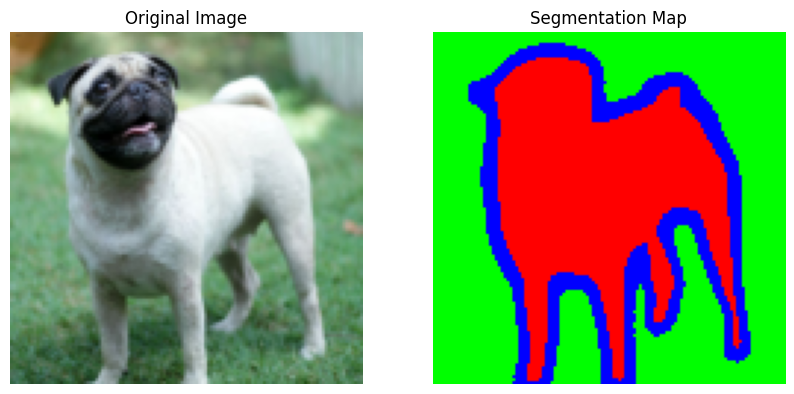

In [7]:
out = net(single_image.unsqueeze(0))
predictions = out["x_recon"]
print(predictions.shape)
predictions=F.one_hot(torch.argmax(predictions,1),3).permute(0,3,1,2).float()
fig = plt.figure(figsize=(10, 5))

# Display the image
ax1 = fig.add_subplot(1, 2, 1)
img = t2img(single_image)
ax1.imshow(img)
ax1.set_title('Original Image')
ax1.axis('off')

# Display the segmentation map
ax2 = fig.add_subplot(1, 2, 2)
# seg_map = one_hot_to_single_channel(predictions.squeeze(0))
# print(seg_map.shape)
seg_map = t2img(predictions.squeeze(0))
ax2.imshow(seg_map)  
ax2.set_title('Segmentation Map')
ax2.axis('off')

In [10]:
# # Get the immediate children of the model as a list
# high_level_children = list(net.children())

# # Print the high-level children modules
# for idx, child in enumerate(high_level_children):
#     print(f"Child {idx}: {child}")

Child 0: Encoder(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (residual_stack): ResidualStack(
    (layers): ModuleList(
      (0-3): 4 x Sequential(
        (0): ReLU()
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU()
        (3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      )
    )
  )
)
Child 1: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
Child 2: VectorQuantizer(
  (N_i_ts): SonnetExponentialMovingAverage()
  (m_i_ts): SonnetExponentialMovingAverage()
)
Child 3: Decoder(
  (conv): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (residual_stack): ResidualStack(
    (layers): ModuleList(
 

### Visualizing filters

In [10]:
def visualize_feature_maps(model, input_image, layer_index):
    print('Visualizing layer',layer_index,' on passing image through model')
    # Function to fetch the output of a specific layer
    # understanding what features of the input image are being highlighted or detected by the specified layer of the model.
    activation = {}
    # The nested function get_activation is defined to create a hook. This hook is a 
    # callback that will be called during the forward pass of the model, specifically when the desired layer has completed its computation.
    def get_activation(name): # to store the activations of the specified layer.
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # Attach the hook to the desired layer
    layer = model.encoder.layers[layer_index]
    handle = layer.register_forward_hook(get_activation('feature_map'))

    # Run the model
    model(input_image)
    handle.remove()

    # Visualize the feature maps
    act = activation['feature_map']
    print('Activations shape',act.shape)
    # Calculate the number of rows needed: one row for every 16 feature maps
    rows = act.size(1) // 16
    # Add an additional row if there are leftover feature maps after filling the rows with 16 feature maps each
    if act.size(1) % 16 != 0:
        rows += 1
    fig, axarr = plt.subplots(rows, 16)

    for idx in range(act.size(1)):
        ax = axarr[idx // 16, idx % 16]
        ax.imshow(act[0, idx].cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.show()
# plt.imshow(act[0, 0].cpu().numpy())

Visualizing layer 0  on passing image through model
Activations shape torch.Size([1, 128, 60, 60])


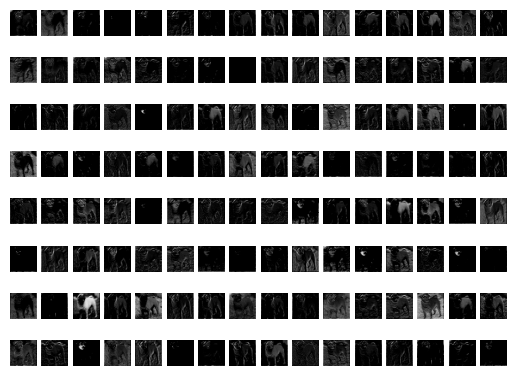

In [11]:
visualize_feature_maps(net, single_image.unsqueeze(0), layer_index=0)
# When this layer processes an input image, each of its 128 filters will apply its 4x4 grid of weights to the input's 3 channels to produce a single feature map. So if you input a single RGB image into this layer, you will get out a batch of 128 feature maps, one for each filter. 

Visualizing layer 1  on passing image through model
Activations shape torch.Size([1, 256, 30, 30])


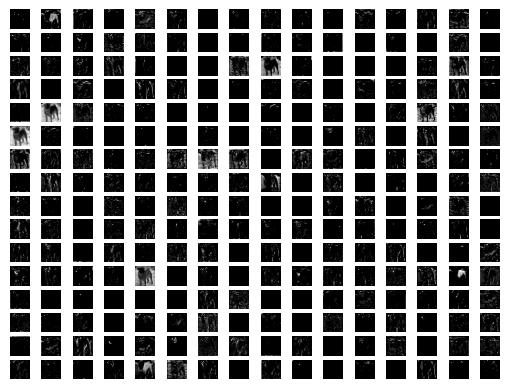

In [12]:
visualize_feature_maps(net, single_image.unsqueeze(0), layer_index=1)

Visualizing layer 2  on passing image through model
Activations shape torch.Size([1, 256, 30, 30])


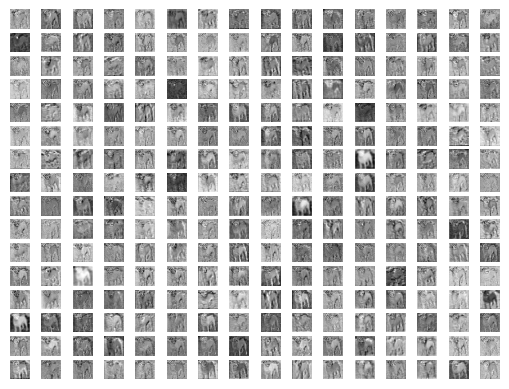

In [13]:
visualize_feature_maps(net, single_image.unsqueeze(0), layer_index=2)

# Embeddings

Embeddings: Since VQ-VAE uses a discrete latent space, you can visualize the learned embeddings. You can use dimensionality reduction techniques like t-SNE or PCA to visualize these embeddings in 2D or 3D. This can help you understand the clustering or grouping of different classes or data points in the embedding space

Nearest Embeddings: For a given input, after it's passed through the encoder, you can find the nearest embeddings and visualize them. This can give you an idea of what features the model is learning.


In [ ]:
# !pip install scikit-learn

In [14]:
torch.manual_seed(4)

In [15]:
# Initialize lists to hold batches of images and targets
images_list = []
targets_list = []
test_dataloader = DataLoader(testing_data, batch_size=64, shuffle=False)
# print(len(test_dataloader),' batches')
# Loop through the dataloader and collect three batches
for i, (images, targets) in enumerate(test_dataloader):
    # Add the entire batch of images and targets to the lists
    images_list.append(images)
    targets_list.append(targets)
    # Break the loop after collecting n batches
    if i == 10:
        break

# Concatenate the batches along the first dimension (batch dimension)
concatenated_images = torch.cat(images_list, dim=0)
concatenated_targets = torch.cat(targets_list, dim=0)

# Now `concatenated_images` and `concatenated_targets` contain the data from the first three batches

In [92]:
concatenated_images.shape

torch.Size([124, 3, 120, 120])

In [16]:
#Pass your input through the encoder and the pre_vq_conv layer to get the latent representations.
# Use the vq layer to get the nearest embeddings.
# Visualize the nearest embeddings
from sklearn.manifold import TSNE

torch.Size([704, 64, 30, 30])


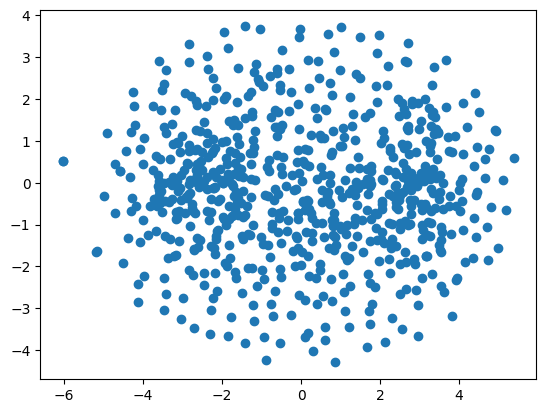

In [17]:
trainpath1 = "seg_vqvae.pt"
net.load_state_dict(torch.load(trainpath1, map_location=torch.device(device)))
# Assume `images` is your input batch
with torch.no_grad():
    images = concatenated_images.to(device)
    z_e_x = net.encoder(images)
    z_e_x = net.pre_vq_conv(z_e_x)
    z_q_x,_,_,_ = net.vq(z_e_x)
print(z_q_x.shape)
# Move the data to cpu and convert to numpy
z_q_x = z_q_x.cpu().numpy()
# Use t-SNE to reduce the dimensionality of the embeddings to 2D
tsne = TSNE(n_components=2, random_state=42)
z_q_x_2d = tsne.fit_transform(z_q_x.reshape(len(z_q_x), -1))
# Plot the 2D embeddings
plt.scatter(z_q_x_2d[:, 0], z_q_x_2d[:, 1])
plt.show()